In [305]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import glob
from scipy.stats import linregress as lin
from scipy.optimize import curve_fit
from datetime import datetime, timedelta
import re

from netCDF4 import Dataset

In [306]:
N = np.size(glob.glob("./dataGt/JPL_mscn*.csv", recursive=True))
M = np.shape(np.genfromtxt('JPL_mscn017.csv', delimiter=',', skip_header=15))[0]

In [307]:
file_n = sorted(glob.glob("./dataGt/JPL_mscn*.csv", recursive=True))
file_ids = np.zeros(len(file_n), dtype=np.int)
area_mscn = np.ones(len(file_n))

data = np.empty((N, M, 2))
for i, fn in enumerate(file_n):
    file = np.genfromtxt(fn, delimiter=',', skip_header=15)
    #print(file.shape,i)
    area_mscn[i] = np.genfromtxt(fn, delimiter=',', skip_header=6, skip_footer=170)[1]
    data[i] = file
    file_ids[i] = int(re.search("JPL_mscn(.+?)csv", fn).group(1)[:-1])

In [308]:
#data[0,:,1] * 1e-2 * area_mscn[0] * 1e6 * 1000 * 1e-12

In [309]:
# Detrend
trends = np.zeros((N, 7))
def fit_f(t, a0, a1, a2, a3, a4, b0, b1):
    lintr = a0 + a1 * t + a2 * t * t
    seasonal = a3 * np.cos(2.0 * np.pi / 365.25 * t + b0)
    halfyear = a4 * np.cos(4.0 * np.pi / 365.25 * t + b1)
    return lintr + seasonal + halfyear

for i in range(N):
    popt, pcov = curve_fit(fit_f, data[i,:,0], data[i,:,1])
    trends[i] = popt

def detrend(data, t, trend):
    return data - trend[0] - trend[1] * t - trend[2] * t ** 2 - trend[3] * np.cos(2.0 * np.pi / 365.25 * t + trend[5]) - trend[4] * np.cos(4.0 * np.pi / 365.25 * t + trend[6])
    
ddata = np.empty((N, M))
for i in range(N):
    ddata[i] = detrend(data[i,:,1], data[i,:,0], trends[i])
    
    


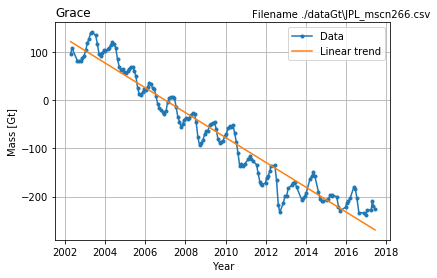

In [310]:
data_num = -1

xlist = 2002 + data[data_num-1][:,0]/365.25
tims = np.array([datetime(2002, 1, 1) + timedelta(days=int(t)) for t in data[data_num-1][:,0]])
ylist = data[data_num-1][:,1]

trend = lin(xlist,ylist)

f, ax = plt.subplots()
ax.plot(xlist,ylist,'.-',label = 'Data')
ax.plot(xlist,xlist * trend[0] + trend[1],label = 'Linear trend')
ax.set_xlabel('Year')
ax.set_ylabel('Mass [Gt]')
plt.title('Grace', loc='left')
plt.legend()
ax.grid()
ax.text(0.58, 0.9, "Filename %s" % (file_n[data_num-1]), transform=f.transFigure)
f.savefig("./Pictures/timeseries_%i.png" % file_ids[data_num-1], dpi=300)
plt.show()

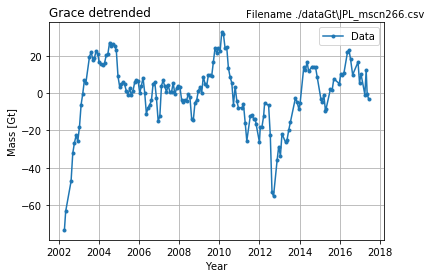

In [311]:
data_num = -1

xlist = 2002 + data[data_num-1][:,0]/365.25
tims = np.array([datetime(2002, 1, 1) + timedelta(days=int(t)) for t in data[data_num-1][:,0]])
ylist = data[data_num-1][:,1]

detrended = detrend(ylist, data[data_num-1][:,0], trends[data_num-1])

f, ax = plt.subplots()
ax.plot(xlist,detrended,'.-',label = 'Data')
ax.set_xlabel('Year')
ax.set_ylabel('Mass [Gt]')
plt.title('Grace detrended', loc='left')
plt.legend()
ax.grid()
ax.text(0.58, 0.9, "Filename %s" % (file_n[data_num-1]), transform=f.transFigure)
f.savefig("./Pictures/timeseries_detrended_%i.png" % file_ids[data_num-1], dpi=300)
plt.show()

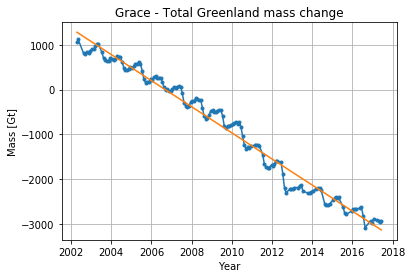

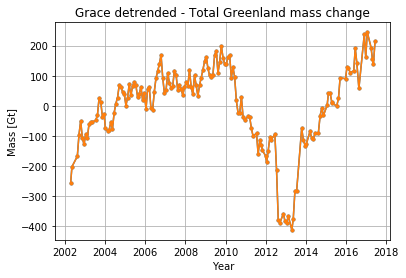

In [312]:
xlist = 2002 + data[0][:,0]/365.25
ylist = np.sum(data, axis = 0)[:,1]

total_trend = curve_fit(fit_f, data[0,:,0], ylist)[0]
total_detrended = detrend(ylist, data[0][:,0], total_trend)
trend = lin(xlist, ylist)

plt.plot(xlist,ylist,'.-',label = 'Data')
plt.plot(xlist,xlist * trend[0] + trend[1],label = 'Linear trend')
plt.title('Grace - Total Greenland mass change')
plt.xlabel('Year')
plt.ylabel('Mass [Gt]')
plt.grid()
plt.savefig("./Pictures/timeseries_total", dpi=300)
plt.show()

plt.plot(xlist,ddata.sum(axis=0),'.-',label = 'Components Detrended')
plt.plot(xlist, total_detrended,'.-',label = 'Total Detrended')

plt.title('Grace detrended - Total Greenland mass change')
plt.xlabel('Year')
plt.ylabel('Mass [Gt]')
plt.grid()
plt.savefig("./Pictures/timeseries_detrended_total", dpi=300)
plt.show()

In [313]:
vel_av = total_trend[1]
acc_av = total_trend[2]
total_time = data[0][-1,0] - data[0][0,0]
print('The average speed is ' + str(np.round(vel_av,decimals=2)) + ' Gt/day.')
print('The average acceleration is ' + str(np.round(acc_av,decimals=6)) + ' Gt/day^2.')
print('The fraction of acceration of the velocity over the total time period is ' + str(np.round(100*acc_av/vel_av*total_time, decimals = 1)) + '%.')

The average speed is -0.67 Gt/day.
The average acceleration is -2.4e-05 Gt/day^2.
The fraction of acceration of the velocity over the total time period is 19.8%.


In [314]:
#F = data[:,:,1].T
F = ddata.T
FT = np.copy(F.T)
for i in range(FT.shape[0]):
    FT[i] -= FT[i].mean()
F = np.copy(FT.T)
C = np.dot(FT, F)
evals, evecs = np.linalg.eig(C)
PCA = np.dot(F, evecs[:])

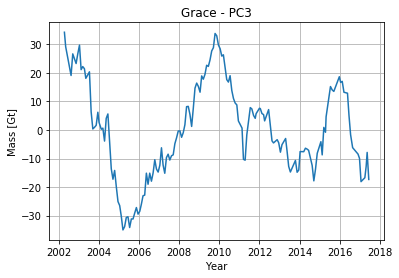

In [315]:
PCA_num = 3

plt.plot(xlist, PCA[:,PCA_num-1])
plt.xlabel('Year')
plt.ylabel('Mass [Gt]')
plt.title('Grace - PC' + str(PCA_num))
plt.grid()
plt.savefig("./Pictures/PC%i_total" %PCA_num, dpi=300)
plt.show()

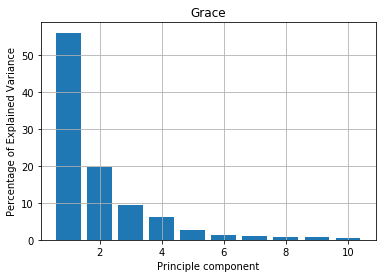

In [316]:
pca_max = 10
bars = evals / evals.sum()*100
plt.bar(x=range(1,pca_max+1), height=bars[:pca_max])
plt.xlabel('Principle component')
plt.ylabel('Percentage of Explained Variance')
plt.title('Grace')
plt.grid()
plt.savefig("./Pictures/PC_explained_total", dpi=300)
plt.show()

In [317]:
R_earth = 6371*10**3
A_earth = 4*np.pi*R_earth**2
N_c = 4551
teta = np.arange(-87,90,3)
teta = 2*np.pi/360*teta

In [318]:
def dellam(teta):
    return(4*np.pi/(np.cos(teta)*N_c* 3/360*2*np.pi))

In [319]:
lamda = np.zeros((teta.size, int(2.0 * np.pi // dellam(0))))
for i in range(teta.size):
    for j in range(lamda.shape[1]):
        lamda[i,j] = (j) * dellam(teta[i])
        if lamda[i,j] >= 2*np.pi:
            lamda[i,j] = np.nan

In [320]:
# testcell
lon = np.zeros(lamda.shape)
for i in range(lamda.shape[0]):
    if 2*np.pi-np.max(lamda[i,:]) < 0.5*lamda[i,1]:
        lon[i,:] = 360/(2*np.pi)*lamda[i,:]*2*np.pi/np.nanmax(lamda[i])
    else:
        siz = np.size(lamda[i,:])-np.isnan(lamda[i,:]).sum()
        lon[i,:] = (siz-1)/siz * 360/(2*np.pi)*lamda[i,:]*2*np.pi/np.nanmax(lamda[i])
        if siz < np.size(lamda[i,:]):
            lon[i,siz] = 360

lat = 360/(2*np.pi)*teta-1.5
#lon = 360/(2*np.pi)*lamda

In [321]:
sdata = data[:,:,1]

In [322]:
def rebin_data(data, lats, irr_lons, true_color=True):
    rl_sz = irr_lons[0].size
    new_sz = 721
    lonspace = np.linspace(0,360,new_sz)
    fit = np.zeros((lat.size, new_sz))
    mask = np.full((lat.size, new_sz), False)
    rlons = None
    
    for k in range(irr_lons.shape[0]):
        sz = np.sum(np.logical_not(np.isnan(irr_lons[k])))
        al = np.zeros(rl_sz)
        ml = np.full(rl_sz, True)
        rlons = irr_lons[k] if sz == irr_lons[k].size else rlons
        if k == 1:
            al[sz-3] = data[0] if true_color else 0.0
            al[sz-2] = data[1] if true_color else 1.0

            ml[sz-3] = False
            ml[sz-2] = False
        if k == 2:
            al[sz-5] = data[2] if true_color else 1.0
            al[sz-4] = data[3] if true_color else 0.0
            al[sz-3] = data[4] if true_color else 1.0
            al[sz-2] = data[5] if true_color else 0.0

            ml[sz-5] = False
            ml[sz-4] = False
            ml[sz-3] = False
            ml[sz-2] = False
        if k == 3:
            al[sz-6] = data[6] if true_color else 0.0
            al[sz-5] = data[7] if true_color else 1.0
            al[sz-4] = data[8] if true_color else 0.0
            al[sz-3] = data[9] if true_color else 1.0

            ml[sz-6] = False
            ml[sz-5] = False
            ml[sz-4] = False
            ml[sz-3] = False
        if k == 4:
            al[sz-7] = data[10] if true_color else 1.0
            al[sz-6] = data[11] if true_color else 0.0
            al[sz-5] = data[12] if true_color else 1.0
            al[sz-4] = data[13] if true_color else 0.0
            al[sz-3] = data[14] if true_color else 1.0

            ml[sz-7] = False
            ml[sz-6] = False
            ml[sz-5] = False
            ml[sz-4] = False
            ml[sz-3] = False
        if k == 5:
            al[sz-7] = data[15] if true_color else 1.0
            al[sz-6] = data[16] if true_color else 0.0
            al[sz-5] = data[17] if true_color else 1.0
            al[sz-4] = data[18] if true_color else 0.0

            ml[sz-7] = False
            ml[sz-6] = False
            ml[sz-5] = False
            ml[sz-4] = False
        if k == 6:
            al[sz-8] = data[19] if true_color else 0.0
            al[sz-7] = data[20] if true_color else 1.0
            al[sz-6] = data[21] if true_color else 0.0
            al[sz-5] = data[22] if true_color else 1.0
            al[sz-4] = data[23] if true_color else 0.0

            ml[sz-8] = False
            ml[sz-7] = False
            ml[sz-6] = False
            ml[sz-5] = False
            ml[sz-4] = False
        if k == 7:
            al[sz-9] = data[24] if true_color else 1.0
            al[sz-8] = data[25] if true_color else 0.0
            al[sz-7] = data[26] if true_color else 1.0
            al[sz-6] = data[27] if true_color else 0.0

            ml[sz-9] = False
            ml[sz-8] = False
            ml[sz-7] = False
            ml[sz-6] = False
        if k == 8:
            al[sz-9] = data[28] if true_color else 1.0
            al[sz-8] = data[29] if true_color else 0.0

            ml[sz-9] = False
            ml[sz-8] = False
        if k == 9:
            al[sz-9] = data[30] if true_color else 0.0
            ml[sz-9] = False
        #fit = np.zeros(lon[29].size)
        j = 0
        for i in range(fit.shape[1]):
            if lonspace[i] > irr_lons[k,j+1] and not np.isnan(irr_lons[k,j+1]):
                j = min(j+1, irr_lons[k].size - 2)
            fit[k,i] = al[j]
            mask[k,i] = ml[j]
        fit[k,-1] = fit[k,0]
        mask[k,-1] = mask[k,0]
    assert(rlons is not None)
    XV, YV = np.meshgrid(lonspace, -lats)
    return XV, YV, np.ma.array(fit, mask=mask)


year = 2009.5
time = np.argmin(np.abs(xlist - year))

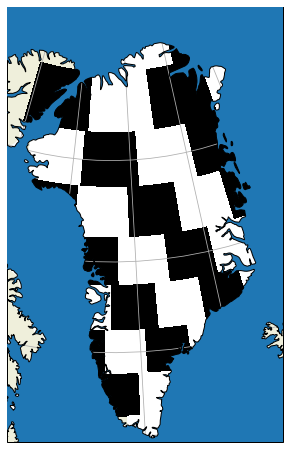

In [323]:
# Dummy Map
XV, YV, dumdata = rebin_data(sdata[:,0], lat, lon, False)
proj = ccrs.LambertConformal(central_latitude=90, central_longitude=310)


f, ax = plt.subplots(figsize=(6, 8), subplot_kw=dict(projection=proj))
cb = ax.pcolor(XV, YV, dumdata, cmap=plt.cm.binary, vmin = 0.0, vmax = 1.0, transform=ccrs.PlateCarree())
ax.set_extent([-65, -25, 59, 85], ccrs.PlateCarree())
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'ocean', '50m'), zorder=100, edgecolor='k')
ax.gridlines()
f.savefig("./Pictures/dummy_map.png", dpi=300)
plt.show()

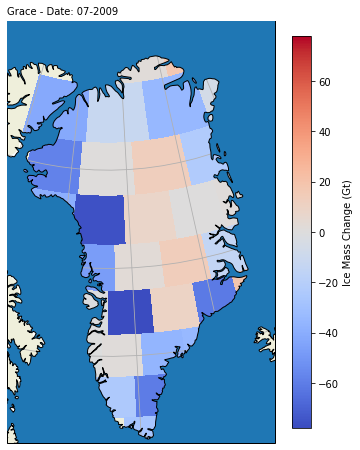

In [324]:
# Verbeterde Plot Routine
XV, YV, fit = rebin_data(sdata[:,time], lat, lon)
proj = ccrs.LambertConformal(central_latitude=90, central_longitude=310)
#proj = ccrs.PlateCarree(central_longitude=310)


f, ax = plt.subplots(figsize=(6, 8), subplot_kw=dict(projection=proj))
cb = ax.pcolor(XV, YV, fit, cmap=plt.cm.coolwarm, vmin = -np.max(np.abs(fit)), vmax = np.max(np.abs(fit)), transform=ccrs.PlateCarree())
ax.set_extent([-65, -25, 59, 85], ccrs.PlateCarree())
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'ocean', '50m'), zorder=100, edgecolor='k')
ax.gridlines()
ax.text(0.125, 0.88, "Grace - Date: %s" % tims[time].strftime("%m-%Y"), transform=f.transFigure)
cax = f.colorbar(cb, ax=[ax], shrink=0.9)
cax.set_label("Ice Mass Change (Gt)")
f.savefig("./Pictures/data_%s_total.png" % tims[time].strftime("%m_%Y"), dpi=300)
plt.show()

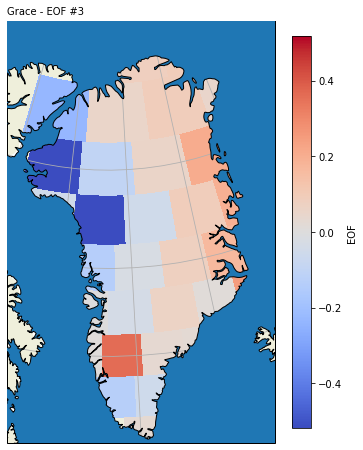

In [325]:
eof_i = 3
XV, YV, eof_fit = rebin_data(evecs[:,eof_i-1], lat, lon)

# Verbeterde Plot Routine
proj = ccrs.LambertConformal(central_latitude=90, central_longitude=310)

f, ax = plt.subplots(figsize=(6, 8), subplot_kw=dict(projection=proj))
cb = ax.pcolor(XV, YV, eof_fit, cmap=plt.cm.coolwarm, vmin = -np.max(np.abs(eof_fit)), vmax = np.max(np.abs(eof_fit)), transform=ccrs.PlateCarree())
ax.set_extent([-65, -25, 59, 85], ccrs.PlateCarree())
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'ocean', '50m'), zorder=100, edgecolor='k')
ax.gridlines()
ax.text(0.125, 0.88, "Grace - EOF #%i" % eof_i, transform=f.transFigure)
cax = f.colorbar(cb, ax=[ax], shrink=0.9)
cax.set_label("EOF")
f.savefig("./Pictures/EOF%i_total.png" % eof_i, dpi=300)
plt.show()

# Regrid Greenland SMB Data

In [326]:
mask = Dataset("./Icemask_Topo_Iceclasses_lon_lat_average_1km.nc", mode='r')
mlon = mask['LON'][:] % 360
mlat = mask['LAT'][:]
mask.close()

lonc = lon[:,:-1] + (lon[:,1:] - lon[:,:-1]) / 2.0
latc = np.array([np.full(lonc.shape[1], l) for l in lat])

In [327]:
create_file = False
import sys

percent = -1.
if create_file:
    data = Dataset("./smb_rec.2002-2017.BN_RACMO2.3p2_FGRN055_GrIS.MM.nc", mode='r')
    T = data['time'][:]
    
    ICE = np.zeros((T.size, lat.size * lonc.shape[1]))
    # Create Index grid
    indices = np.zeros(mlon.shape, dtype=int)
    for yi in range(mlat.shape[0]):
        for xi in range(mlat.shape[1]):
            L = np.sqrt((mlon[yi,xi] - lonc) ** 2 + (mlat[yi,xi] - latc) ** 2)
            indices[yi,xi] = np.nanargmin(L)
        sys.stdout.write("%i/%i\r" % (yi + 1, mlat.shape[0]))
        sys.stdout.flush()
    sys.stdout.write("\n")
        
    # Rebin each original data point
    indices = indices.flatten()
    for i in range(indices.size):    
        ICE[:,indices[i]] += data['SMB_rec'][:,i//mlon.shape[1], i%mlon.shape[1]]
        if (i % 500) == 0:
            sys.stdout.write("\r%i/%i" % (i + 1, indices.size))
            sys.stdout.flush()
    sys.stdout.write("\r%i/%i\n" % (indices.size, indices.size))
    data.close()
    
    # Mean SMB
    ICE_M = np.copy(ICE)
    for i, c in zip(*np.unique(indices, return_counts=True)):
        ICE_M[:,i] /= c
    
    mask = np.full((T.size, lat.size, lonc.shape[1]), np.isnan(lon[:,1:]))
    ICE = ICE.reshape((T.size, lat.size, lonc.shape[1]))
    ICE_M = ICE_M.reshape((T.size, lat.size, lonc.shape[1]))
    
    ICE = np.ma.array(ICE, mask=mask)
    ICE_M = np.ma.array(ICE_M, mask=mask)
    
    data = Dataset("./ICE_mascon.nc", mode='w')
    data.createDimension('time', T.size)
    data.createDimension('y', ICE.shape[1])
    data.createDimension('x', ICE.shape[2])

    data.createVariable("time", "f4", ("time",))
    data.createVariable("SSMB", "f4", ("time", "y", "x",))
    data.createVariable("SMB", "f4", ("time", "y", "x",))

    data['time'][:] = T
    data['SSMB'][:] = ICE
    data['SMB'][:] = ICE_M
    data.close()
    
    SMB = ICE_M
else:
    data = Dataset("./ICE_mascon.nc", mode='r')
    T = data['time'][:]
    SMB = data['SMB'][:]
    data.close()

In [328]:
FSMB = np.flip(SMB, axis=1)#.reshape((T.size, SMB.shape[1] * SMB.shape[2]))
false_i = np.ones(FSMB.shape[1], dtype=int) * FSMB.shape[1]
for i in range(FSMB.shape[1]):
    index = np.argwhere(FSMB[0,i,:].mask)
    false_i[i] = index[0][0] if index.shape[0] != 0 else false_i[i]

print(false_i)
mscn_SMB = np.zeros((31, T.size))
for lat_i in range(1, 10):
    if lat_i == 1:
        mscn_SMB[0,:] = FSMB[:,lat_i,false_i[lat_i] - 1] * area_mscn[0]
        mscn_SMB[1,:] = FSMB[:,lat_i,false_i[lat_i] - 2] * area_mscn[1]
    if lat_i == 2:
        mscn_SMB[2,:] = FSMB[:,lat_i,false_i[lat_i] - 1] * area_mscn[2]
        mscn_SMB[3,:] = FSMB[:,lat_i,false_i[lat_i] - 2] * area_mscn[3]
        mscn_SMB[4,:] = FSMB[:,lat_i,false_i[lat_i] - 3] * area_mscn[4]
        mscn_SMB[5,:] = FSMB[:,lat_i,false_i[lat_i] - 4] * area_mscn[5]
    if lat_i == 3:
        mscn_SMB[6,:] = FSMB[:,lat_i,false_i[lat_i] - 2] * area_mscn[6]
        mscn_SMB[7,:] = FSMB[:,lat_i,false_i[lat_i] - 3] * area_mscn[7]
        mscn_SMB[8,:] = FSMB[:,lat_i,false_i[lat_i] - 4] * area_mscn[8]
        mscn_SMB[9,:] = FSMB[:,lat_i,false_i[lat_i] - 5] * area_mscn[9]
    if lat_i == 4:
        mscn_SMB[10,:] = FSMB[:,lat_i,false_i[lat_i] - 2] * area_mscn[10]
        mscn_SMB[11,:] = FSMB[:,lat_i,false_i[lat_i] - 3] * area_mscn[11]
        mscn_SMB[12,:] = FSMB[:,lat_i,false_i[lat_i] - 4] * area_mscn[12]
        mscn_SMB[13,:] = FSMB[:,lat_i,false_i[lat_i] - 5] * area_mscn[13]
        mscn_SMB[14,:] = FSMB[:,lat_i,false_i[lat_i] - 6] * area_mscn[14]
    if lat_i == 5:
        mscn_SMB[15,:] = FSMB[:,lat_i,false_i[lat_i] - 3] * area_mscn[15]
        mscn_SMB[16,:] = FSMB[:,lat_i,false_i[lat_i] - 4] * area_mscn[16]
        mscn_SMB[17,:] = FSMB[:,lat_i,false_i[lat_i] - 5] * area_mscn[17]
        mscn_SMB[18,:] = FSMB[:,lat_i,false_i[lat_i] - 6] * area_mscn[18]
    if lat_i == 6:
        mscn_SMB[19,:] = FSMB[:,lat_i,false_i[lat_i] - 3] * area_mscn[19]
        mscn_SMB[20,:] = FSMB[:,lat_i,false_i[lat_i] - 4] * area_mscn[20]
        mscn_SMB[21,:] = FSMB[:,lat_i,false_i[lat_i] - 5] * area_mscn[21]
        mscn_SMB[22,:] = FSMB[:,lat_i,false_i[lat_i] - 6] * area_mscn[22]
        mscn_SMB[23,:] = FSMB[:,lat_i,false_i[lat_i] - 7] * area_mscn[23]
    if lat_i == 7:
        mscn_SMB[24,:] = FSMB[:,lat_i,false_i[lat_i] - 5] * area_mscn[24]
        mscn_SMB[25,:] = FSMB[:,lat_i,false_i[lat_i] - 6] * area_mscn[25]
        mscn_SMB[26,:] = FSMB[:,lat_i,false_i[lat_i] - 7] * area_mscn[26]
        mscn_SMB[27,:] = FSMB[:,lat_i,false_i[lat_i] - 8] * area_mscn[27]
    if lat_i == 8:
        mscn_SMB[28,:] = FSMB[:,lat_i,false_i[lat_i] - 7] * area_mscn[28]
        mscn_SMB[29,:] = FSMB[:,lat_i,false_i[lat_i] - 8] * area_mscn[29]
    if lat_i == 9:
        mscn_SMB[30,:] = FSMB[:,lat_i,false_i[lat_i] - 8] * area_mscn[30]

mscn_SMB *= 1e-6 # From mm * km^2 to Gt
#mscn_SMB *= 1e-1

[  7  13  19  25  31  37  43  49  55  60  65  71  75  80  85  89  93  97
 100 104 107 109 112 114 116 117  59  59  59  59  59  59  59 117 116 114
 112 109 107 104 100  97  93  89  85  80  75  71  65  60  55  49  43  37
  31  25  19  13   7]


In [329]:
mscn_SMB.max()

22.183726

In [330]:
T_days = np.zeros(T.size)
for ti, tv in enumerate(T):
    T_int = int(np.round(tv))
    T_days[ti] = (datetime(2002 + T_int // 12, T_int % 12 + 1, 1) - datetime(2002, 1, 1)).days
    
tims2 = np.array([datetime(2002, 1, 1) + timedelta(days=int(t)) for t in T_days])


In [331]:
# Detrend SMB
SMB_trends = np.zeros((N, 7))
def fit_f(t, a0, a1, a2, a3, a4, b0, b1):
    lintr = a0 + a1 * t + a2 * t * t
    seasonal = a3 * np.cos(2.0 * np.pi / 365.25 * t + b0)
    halfyear = a4 * np.cos(4.0 * np.pi / 365.25 * t + b1)
    return lintr + seasonal + halfyear

for i in range(N):
    popt, pcov = curve_fit(fit_f, T_days , mscn_SMB[i,:])
    SMB_trends[i] = popt

def detrend(data, t, trend):
    return data - trend[0] - trend[1] * t - trend[2] * t ** 2 - trend[3] * np.cos(2.0 * np.pi / 365.25 * t + trend[5]) - trend[4] * np.cos(4.0 * np.pi / 365.25 * t + trend[6])
    
SMB_detrended = np.empty(mscn_SMB.shape)
for i in range(N):
    SMB_detrended[i] = detrend(mscn_SMB[i,:], T_days, SMB_trends[i])
    

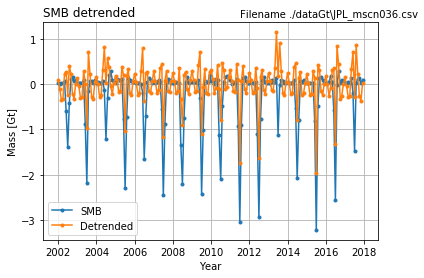

In [332]:
# Extra Plots
data_num = 6

f, ax = plt.subplots()
ax.plot(T / 12 + 2002, mscn_SMB[data_num-1],'.-',label = 'SMB')
ax.plot(T / 12 + 2002, SMB_detrended[data_num-1],'.-',label = 'Detrended')

ax.set_xlabel('Year')
ax.set_ylabel('Mass [Gt]')
plt.title('SMB detrended', loc='left')
plt.legend()
ax.grid()
ax.text(0.58, 0.9, "Filename %s" % (file_n[data_num-1]), transform=f.transFigure)
f.savefig("./Pictures/timeseries_%i_SMB" % file_ids[data_num-1], dpi=300)
plt.show()

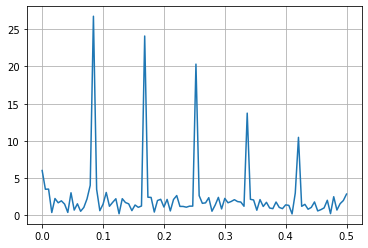

In [333]:
from scipy.fftpack import fft
F = fft(mscn_SMB[0])
H = np.linspace(0.0, 1. / 2., mscn_SMB.shape[1] // 2)
plt.plot(H, np.abs(F[:F.size//2]))
plt.grid()
plt.show()


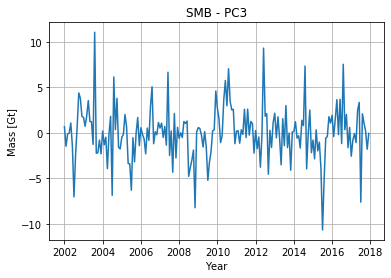

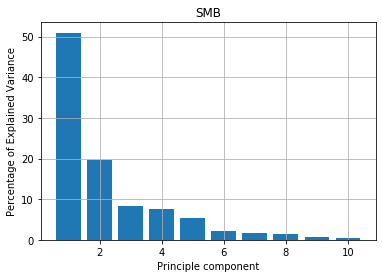

In [334]:
F_SMB = SMB_detrended.T
F_SMBT = np.copy(F_SMB.T)
for i in range(F_SMBT.shape[0]):
    F_SMBT[i] -= F_SMBT[i].mean()
F_SMB = np.copy(F_SMBT.T)
C = np.dot(F_SMBT, F_SMB)
eval_smb, evec_smb = np.linalg.eig(C)
PCA_SMB = np.dot(F_SMB, evec_smb[:])

# Plot PCA
PCA_num = 3

plt.plot(T / 12 + 2002, PCA_SMB[:,PCA_num-1])
plt.xlabel('Year')
plt.ylabel('Mass [Gt]')
plt.title('SMB - PC' + str(PCA_num))
plt.grid()
plt.savefig("./Pictures/PC%i_SMB.png" % file_ids[PCA_num-1], dpi=300)
plt.show()

pca_max = 10
bars = eval_smb / eval_smb.sum()*100
plt.bar(x=range(1,pca_max+1), height=bars[:pca_max])
plt.title('SMB')
plt.xlabel('Principle component')
plt.ylabel('Percentage of Explained Variance')
plt.grid()
plt.savefig("./Pictures/PC_explained_SMB", dpi=300)
plt.show()

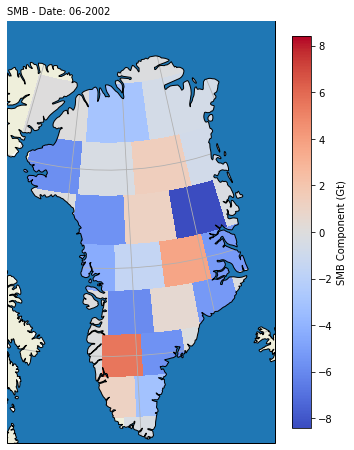

In [335]:
# Verbeterde Plot Routine
time = 5
XV, YV, fit = rebin_data(mscn_SMB[:,time], lat, lon)
proj = ccrs.LambertConformal(central_latitude=90, central_longitude=310)
#proj = ccrs.PlateCarree(central_longitude=310)


f, ax = plt.subplots(figsize=(6, 8), subplot_kw=dict(projection=proj))
cb = ax.pcolor(XV, YV, fit, cmap=plt.cm.coolwarm, vmin = -np.max(np.abs(fit)), vmax = np.max(np.abs(fit)), transform=ccrs.PlateCarree())
ax.set_extent([-65, -25, 59, 85], ccrs.PlateCarree())
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'ocean', '50m'), zorder=100, edgecolor='k')
ax.gridlines()
ax.text(0.125, 0.88, "SMB - Date: %s" % tims2[time].strftime("%m-%Y"), transform=f.transFigure)
cax = f.colorbar(cb, ax=[ax], shrink=0.9)
cax.set_label("SMB Component (Gt)")
f.savefig("./Pictures/SMB_map_%s.png" % tims2[time].strftime("%m-%Y"))
plt.show()

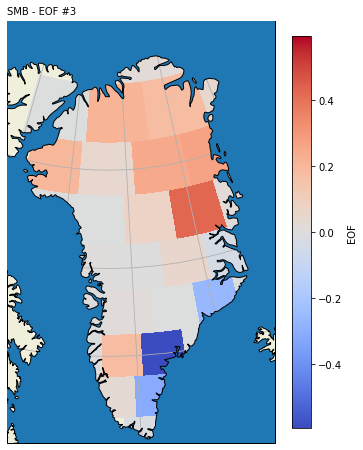

In [336]:
eof_i = 3
XV, YV, eof_fit = rebin_data(evec_smb[:,eof_i-1], lat, lon)

# Verbeterde Plot Routine
proj = ccrs.LambertConformal(central_latitude=90, central_longitude=310)

f, ax = plt.subplots(figsize=(6, 8), subplot_kw=dict(projection=proj))
cb = ax.pcolor(XV, YV, eof_fit, cmap=plt.cm.coolwarm, vmin = -np.max(np.abs(eof_fit)), vmax = np.max(np.abs(eof_fit)), transform=ccrs.PlateCarree())
ax.set_extent([-65, -25, 59, 85], ccrs.PlateCarree())
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'ocean', '50m'), zorder=100, edgecolor='k')
ax.gridlines()
ax.text(0.125, 0.88, "SMB - EOF #%i" % eof_i, transform=f.transFigure)
cax = f.colorbar(cb, ax=[ax], shrink=0.9)
cax.set_label("EOF")
f.savefig("./Pictures/EOF%i_SMB.png" % eof_i, dpi=300)
plt.show()

# Determining Run-off

In [337]:
matching_inds = np.full(tims.size, -1, dtype=int)
for i in range(tims.size):
    cyear, cmonth = (tims[i].year, tims[i].month)
    for j in range(tims2.size):
        if tims2[j].year == cyear and tims2[j].month == cmonth:
            matching_inds[i] = j
            break
SMB_inds = SMB_detrended.T[matching_inds].T
run_off = ddata - SMB_inds

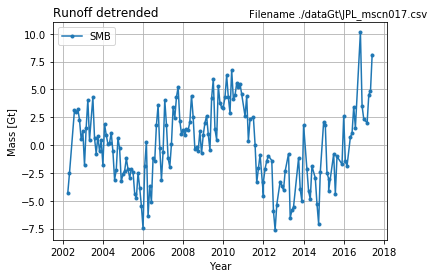

In [338]:
# Extra Plots
data_num = 1

f, ax = plt.subplots()
ax.plot(T[matching_inds] / 12 + 2002, run_off[data_num-1],'.-',label = 'SMB')
ax.set_xlabel('Year')
ax.set_ylabel('Mass [Gt]')
plt.title('Runoff detrended', loc='left')
plt.legend()
ax.grid()
ax.text(0.58, 0.9, "Filename %s" % (file_n[data_num-1]), transform=f.transFigure)
f.savefig("./Pictures/timeseries_%i_runoff" % file_ids[data_num-1], dpi=300)
plt.show()

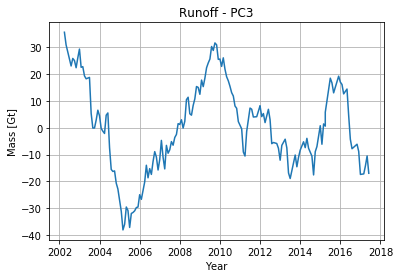

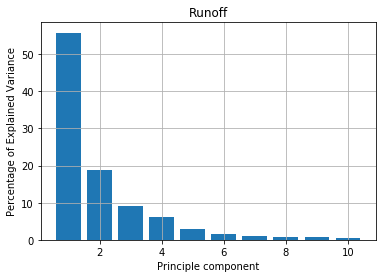

In [339]:
# PCA Analysis

R = run_off.T
RT = np.copy(R.T)
for i in range(RT.shape[0]):
    RT[i] -= RT[i].mean()
R = np.copy(RT.T)
C = np.dot(RT, R)
evals_r, evecs_r = np.linalg.eig(C)
PCA_r = np.dot(R, evecs_r[:])

# Plot PCA
PCA_num = 3

plt.plot(T[matching_inds] / 12 + 2002, PCA_r[:,PCA_num-1])
plt.xlabel('Year')
plt.ylabel('Mass [Gt]')
plt.title('Runoff - PC' + str(PCA_num))
plt.grid()
plt.savefig("./Pictures/PC%i_runoff.png" % PCA_num, dpi=300)
plt.show()

pca_max = 10
bars = evals_r / evals_r.sum()*100
plt.bar(x=range(1,pca_max+1), height=bars[:pca_max])
plt.title('Runoff')
plt.xlabel('Principle component')
plt.ylabel('Percentage of Explained Variance')
plt.grid()
plt.savefig("./Pictures/PC_explained_runoff", dpi=300)
plt.show()

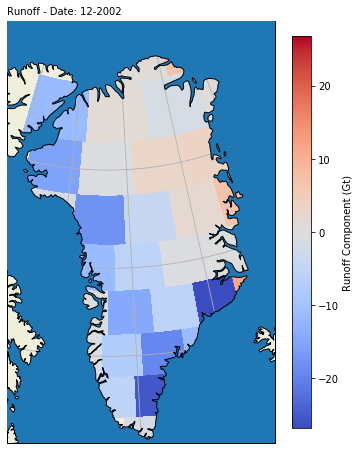

In [340]:
# Verbeterde Plot Routine
time = 6
XV, YV, fit = rebin_data(run_off[:,time], lat, lon)
proj = ccrs.LambertConformal(central_latitude=90, central_longitude=310)
#proj = ccrs.PlateCarree(central_longitude=310)


f, ax = plt.subplots(figsize=(6, 8), subplot_kw=dict(projection=proj))
cb = ax.pcolor(XV, YV, fit, cmap=plt.cm.coolwarm, vmin = -np.max(np.abs(fit)), vmax = np.max(np.abs(fit)), transform=ccrs.PlateCarree())
ax.set_extent([-65, -25, 59, 85], ccrs.PlateCarree())
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'ocean', '50m'), zorder=100, edgecolor='k')
ax.gridlines()
ax.text(0.125, 0.88, "Runoff - Date: %s" % tims[time].strftime("%m-%Y"), transform=f.transFigure)
cax = f.colorbar(cb, ax=[ax], shrink=0.9)
cax.set_label("Runoff Component (Gt)")
f.savefig("./Pictures/runoff_map_%s.png" % tims2[time].strftime("%m-%Y"))

plt.show()

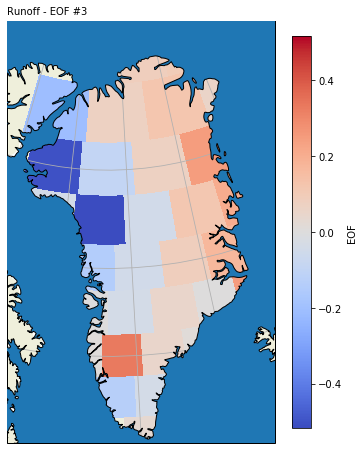

In [341]:
eof_i = 3
XV, YV, eof_fit = rebin_data(evecs_r[:,eof_i-1], lat, lon)

# Verbeterde Plot Routine
proj = ccrs.LambertConformal(central_latitude=90, central_longitude=310)

f, ax = plt.subplots(figsize=(6, 8), subplot_kw=dict(projection=proj))
cb = ax.pcolor(XV, YV, eof_fit, cmap=plt.cm.coolwarm, vmin = -np.max(np.abs(eof_fit)), vmax = np.max(np.abs(eof_fit)), transform=ccrs.PlateCarree())
ax.set_extent([-65, -25, 59, 85], ccrs.PlateCarree())
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'ocean', '50m'), zorder=100, edgecolor='k')
ax.gridlines()
ax.text(0.125, 0.88, "Runoff - EOF #%i" % eof_i, transform=f.transFigure)
cax = f.colorbar(cb, ax=[ax], shrink=0.9)
cax.set_label("EOF")
f.savefig("./Pictures/EOF%i_runoff.png" % eof_i, dpi=300)

plt.show()